### Performance on Onboarding
---



In [3]:
# pip install --index-url https://build.sofi.com/artifactory/api/pypi/pypi/simple -r ../../requirements.txt --use-deprecated=legacy-resolver

In [3]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from src.combine import combine_data
from src.monitoring.download_customer_prod import download_customer_prod_data

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

In [4]:
# load dev data
dev_df = pd.read_feather("../../data/combined_all_features/combined_1637115975.feather")
dev_df = dev_df[dev_df.sample_date==pd.to_datetime("2021-11-03")]

(1596151, 57)

<AxesSubplot:>

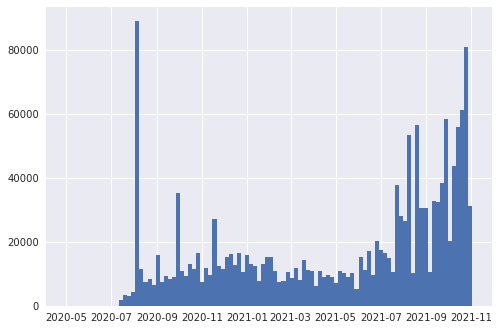

In [5]:
# load prod data
output_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod_11_02.parquet"
prod_df = pd.read_parquet(output_path)

prod_df["created_date"] = pd.to_datetime(prod_df.created_dt).dt.date
prod_df["last_checked_date"] = pd.to_datetime(prod_df.last_checked_date).dt.date
display(prod_df.shape)
prod_df["created_date"].hist(bins=100)

In [6]:
last_batch_date = pd.to_datetime("2021-10-27")
prod_df_new = prod_df[prod_df.created_date > last_batch_date]

prod_df_new[prod_df_new.request_source=='"onboarding"'].shape

(30468, 57)

#### Mask with Default

In [7]:
default_values = {
    'transaction_as_pct_of_balance': 0,
    'max_withdrawals_30d': 0,
    'max_deposits_30d': 0,
    'pct_returned_deposits': 0,
    'bal_ratio': 0,
    'sum_deposits_10d': 0,
    'mean_account_balance_30d': 0,
    'dollar_val_dd': 0,
    'nr_direct_deposits': 0,
    'nr_past_transactions': -1,  # -1 is the default in production where we have 0 in dev...
    'dollar_val_returns': 0,
    'dollar_val_returns_3d': 0,
    'nr_returns_30d': 0,
    'time_since_last_transaction': -1,
    'nr_trans_ratio': -1,
    'first_deposit_amount': -1,
    'lag_acc_open_first_transaction': -1,
    'transaction_code_encoded': 0,  
}

tfts = ['transaction_as_pct_of_balance',
     'time_since_last_transaction',
     'nr_past_transactions',
     'pct_returned_deposits',
     'dollar_val_returns',
     'dollar_val_returns_3d',
     'mean_account_balance_30d',
     'sum_deposits_10d',
     'max_deposits_30d',
     'max_withdrawals_30d',
     'nr_direct_deposits',
     'bal_ratio',
     'dollar_val_dd',
     'nr_returns_30d',
     'nr_trans_ratio',
     'transaction_code_encoded'
]

vcs = {}
for f in default_values:
     vcs[f] = (prod_df_new[f] == default_values[f]).value_counts()
        
is_default_df = pd.concat(vcs).unstack()
is_default_df["pct_default"] = is_default_df[True] / (is_default_df[False] + is_default_df[True])

is_default_df.loc[tfts]

,True,False,pct_default
transaction_as_pct_of_balance,30614,439,0.985863
time_since_last_transaction,30560,493,0.984124
nr_past_transactions,30440,613,0.980260
pct_returned_deposits,31003,50,0.998390
dollar_val_returns,31003,50,0.998390
dollar_val_returns_3d,31014,39,0.998744
mean_account_balance_30d,30596,457,0.985283
sum_deposits_10d,30765,288,0.990726
max_deposits_30d,30762,291,0.990629
max_withdrawals_30d,30727,326,0.989502


In [8]:
new_ids = prod_df_new.party_id.unique()
ids = dev_df.user_id.unique()
no_ids = prod_df_new[prod_df_new.party_id.isin(set(new_ids) - set(ids))]

len(no_ids)

12902

13k users in prod does not appear in dev. Find out why.

In [9]:
no_ids.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
361,10293997,2021-10-28 15:37:13.614,2021-10-28 19:33:26.233,2021-10-28,2021-10-28 19:33:26.232,"""RG4B""","""onboarding""",592.725389,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,24.0,50985.0,1.0,1958.0,0.0,2143.0,0,-1.0,-1.0,2021-10-28
1647,297940,2021-10-28 14:16:39.621,2021-10-28 14:17:36.439,2021-10-28,2021-10-28 14:17:36.437,"""RG5""","""onboarding""",681.032172,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,0.0,0.0,NaN,0.0,0.0,0,999.0,999.0,2021-10-28
1863,2601113,2021-10-28 01:47:56.187,2021-10-28 01:48:49.928,2021-10-28,2021-10-28 01:48:49.927,"""RG5""","""onboarding""",682.401465,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,3.0,3224.0,2.0,1584.0,0.0,0.0,0,-1.0,996.0,2021-10-28
2013,10404642,2021-10-28 03:02:37.658,2021-10-28 03:03:01.159,2021-10-28,2021-10-28 03:03:01.158,"""RG5""","""onboarding""",667.170020,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,6.0,0.0,2.0,6055.0,1.0,2506.0,0,-1.0,-1.0,2021-10-28
2040,10719932,2021-10-28 02:51:28.096,None,2021-10-28,2021-10-28 02:51:28.094,"""RG5""","""onboarding""",696.981379,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-28


In [26]:
no_ids[no_ids.party_id.isin([10584064,
 20676609,
 20709378])]

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
123886,10584064,2021-10-28 04:19:43.255,None,2021-10-28,2021-10-28 04:19:43.253,"""RG5""","""onboarding""",636.404050,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,7.0,38158.0,1.0,26645.0,0.0,204.0,0,-1.0,-1.0,2021-10-28
1455807,20709378,2021-10-31 19:13:59.636,None,2021-10-31,2021-10-31 19:13:59.634,"""RG5""","""onboarding""",660.923098,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-31
1568594,20676609,2021-10-29 02:44:13.353,None,2021-10-29,2021-10-29 02:44:13.351,"""RG5""","""onboarding""",646.506261,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-29


In [28]:
no_ids[no_ids.party_id.isin([10584064,
                             20676609,
                             20709378,
                            19791897])].T

,123886,1442236,1455807,1568594
party_id,10584064,19791897,20709378,20676609
created_dt,2021-10-28 04:19:43.255,2021-10-30 07:14:54.159,2021-10-31 19:13:59.636,2021-10-29 02:44:13.353
updated_dt,None,2021-10-30 07:15:00.060,None,None
last_checked_date,2021-10-28,2021-10-30,2021-10-31,2021-10-29
last_checked_date_max,2021-10-28 04:19:43.253,2021-10-30 07:15:00.058,2021-10-31 19:13:59.634,2021-10-29 02:44:13.351
risk_group,"""RG5""","""RG5""","""RG5""","""RG5"""
request_source,"""onboarding""","""onboarding""","""onboarding""","""onboarding"""
model_score,636.40405,683.208268,660.923098,646.506261
model_decision_rule_details,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","[{""ruleName"":""isMember"",""rulePassed"":false,""ri..."
mcustomer_model_risk_groupodel_score,"""RG5""","""RG5""","""RG5""","""RG5"""


In [15]:
bkaccts = pd.read_feather("../../data/raw/raw_1637099119/banking_accounts_1637099119.feather")

In [20]:
len(set(no_ids.party_id).intersection(set(bkaccts.user_id)))

335

In [29]:
declined_new_ids = set(no_ids.party_id.unique()) - set(bkaccts.user_id.unique())
len(declined_new_ids)

12567

In [33]:
df_tmp = prod_df_new[prod_df_new.party_id.isin(declined_new_ids)].head()
df_tmp

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
361,10293997,2021-10-28 15:37:13.614,2021-10-28 19:33:26.233,2021-10-28,2021-10-28 19:33:26.232,"""RG4B""","""onboarding""",592.725389,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4B""",...,24.0,50985.0,1.0,1958.0,0.0,2143.0,0,-1.0,-1.0,2021-10-28
1647,297940,2021-10-28 14:16:39.621,2021-10-28 14:17:36.439,2021-10-28,2021-10-28 14:17:36.437,"""RG5""","""onboarding""",681.032172,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,0.0,0.0,0.0,NaN,0.0,0.0,0,999.0,999.0,2021-10-28
1863,2601113,2021-10-28 01:47:56.187,2021-10-28 01:48:49.928,2021-10-28,2021-10-28 01:48:49.927,"""RG5""","""onboarding""",682.401465,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,3.0,3224.0,2.0,1584.0,0.0,0.0,0,-1.0,996.0,2021-10-28
2013,10404642,2021-10-28 03:02:37.658,2021-10-28 03:03:01.159,2021-10-28,2021-10-28 03:03:01.158,"""RG5""","""onboarding""",667.170020,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,6.0,0.0,2.0,6055.0,1.0,2506.0,0,-1.0,-1.0,2021-10-28
2040,10719932,2021-10-28 02:51:28.096,None,2021-10-28,2021-10-28 02:51:28.094,"""RG5""","""onboarding""",696.981379,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2021-10-28


In [39]:
from pprint import pprint

In [41]:
i = 0
drd = df_tmp.model_decision_rule_details.iloc[i]
pprint(json.loads(drd))

[{'riskGroupCode': 'RG1', 'ruleName': 'isMember', 'rulePassed': False},
 {'riskGroupCode': 'RG1', 'ruleName': 'noRecentAch', 'rulePassed': True},
 {'riskGroupCode': 'RG1', 'ruleName': 'notHighRisk', 'rulePassed': True},
 {'riskGroupCode': 'RG1', 'ruleName': 'isPlMoneyBundle', 'rulePassed': False},
 {'riskGroupCode': 'RG1', 'ruleName': 'allPass', 'rulePassed': False}]


In [51]:
new_df_w_tgt = pd.merge(prod_df_new, dev_df[["user_id", "target"]],
                        left_on="party_id", right_on="user_id", how="inner",
                        suffixes=("", "_"))

In [54]:
# missing 12k records... where are they? 
# - we looked at a many and all are declined by decision rules
new_df_w_tgt.target.value_counts()

False    18143
True        24
Name: target, dtype: int64

In [56]:
from src.monitoring.utils import preprocess, scale_scores

new_df_w_tgt_default = new_df_w_tgt.copy(deep=True)
for f in default_values:
    print(f)
    new_df_w_tgt_default[f] = default_values[f]
new_df_w_tgt_default = preprocess(new_df_w_tgt_default)

transaction_as_pct_of_balance
max_withdrawals_30d
max_deposits_30d
pct_returned_deposits
bal_ratio
sum_deposits_10d
mean_account_balance_30d
dollar_val_dd
nr_direct_deposits
nr_past_transactions
dollar_val_returns
dollar_val_returns_3d
nr_returns_30d
time_since_last_transaction
nr_trans_ratio
first_deposit_amount
lag_acc_open_first_transaction
transaction_code_encoded


#### Eval

In [57]:
import pickle as pkl
from smart_open import open

incumbent_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl"
with open(incumbent_model_path, "rb") as f:
    incumbent_model = pkl.load(f)
    
refit_model_path = "s3://sofi-data-science/jxu/money-risk-models/models/customer_risk_refit_20201231_wo_ind.pkl"
with open(refit_model_path, "rb") as f:
    refit_model = pkl.load(f)

In [85]:
# original
new_df_w_tgt["refitted_model_pred"] = refit_model.predict_proba(new_df_w_tgt[refit_model.feature_name_])[:,1]
new_df_w_tgt["refitted_model_score"] = scale_scores(new_df_w_tgt["refitted_model_pred"])

new_df_w_tgt["incumbent_model_pred"] = incumbent_model.predict_proba(new_df_w_tgt[incumbent_model.feature_name_])[:,1]
new_df_w_tgt["incumbent_model_score"] = scale_scores(new_df_w_tgt["incumbent_model_pred"])

In [86]:
# overwritten with default
new_df_w_tgt["refitted_model_pred_w_default"] = refit_model.predict_proba(new_df_w_tgt_default[refit_model.feature_name_])[:,1]
new_df_w_tgt["refitted_model_score_w_default"] = scale_scores(new_df_w_tgt["refitted_model_pred_w_default"])

new_df_w_tgt["incumbent_model_pred_w_default"] = incumbent_model.predict_proba(new_df_w_tgt_default[incumbent_model.feature_name_])[:,1]
new_df_w_tgt["incumbent_model_score_w_default"] = scale_scores(new_df_w_tgt["incumbent_model_pred_w_default"])

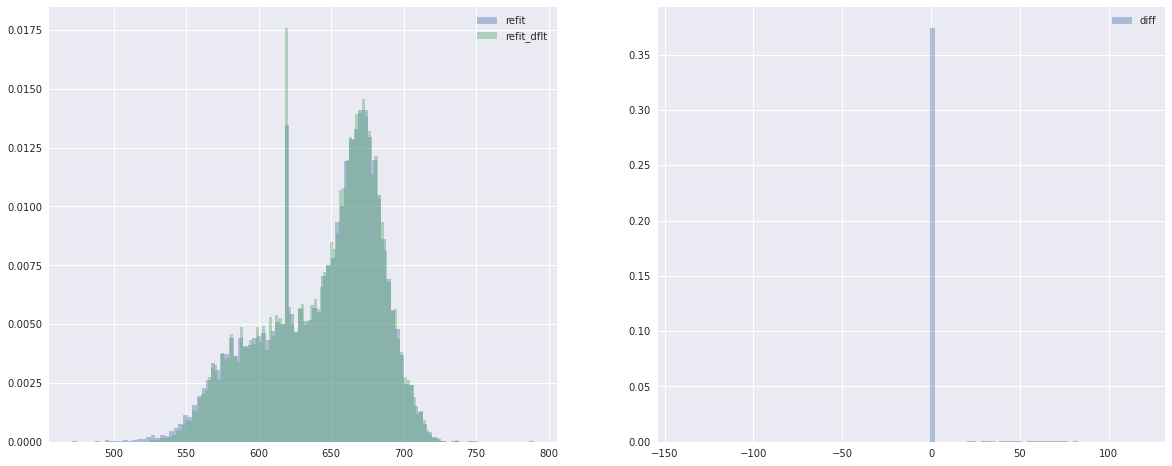

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt_params = {"alpha": 0.4,
              "bins": 100,
              "density": True}

ax = axs[0]
new_df_w_tgt["refitted_model_score"].hist(**plt_params, label="refit", ax=ax)
new_df_w_tgt["refitted_model_score_w_default"].hist(**plt_params, label="refit_dflt", ax=ax)
ax.legend()

ax = axs[1]
diff = new_df_w_tgt["refitted_model_score_w_default"] - new_df_w_tgt["refitted_model_score"]
diff.hist(**plt_params, label="diff", ax=ax)
ax.legend()

In [ ]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 600, 850],  # new rg proposal
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

new_df_w_tgt["rg_refitted"] = get_risk_groups_refitted(new_df_w_tgt["refitted_model_score"])
new_df_w_tgt["rg_incumbent"] = get_risk_groups(new_df_w_tgt["incumbent_model_score"])

new_df_w_tgt["rg_refitted_w_default"] = get_risk_groups_refitted(new_df_w_tgt["refitted_model_score_w_default"])
new_df_w_tgt["rg_incumbent_w_default"] = get_risk_groups(new_df_w_tgt["incumbent_model_score_w_default"])

In [72]:
diff.value_counts(normalize=True)

 0.000000     0.970826
-0.469390     0.000330
-0.134054     0.000110
 31.967322    0.000055
 48.188965    0.000055
                ...   
 85.335794    0.000055
 39.220636    0.000055
 74.987206    0.000055
 43.287918    0.000055
-10.683662    0.000055
Length: 525, dtype: float64

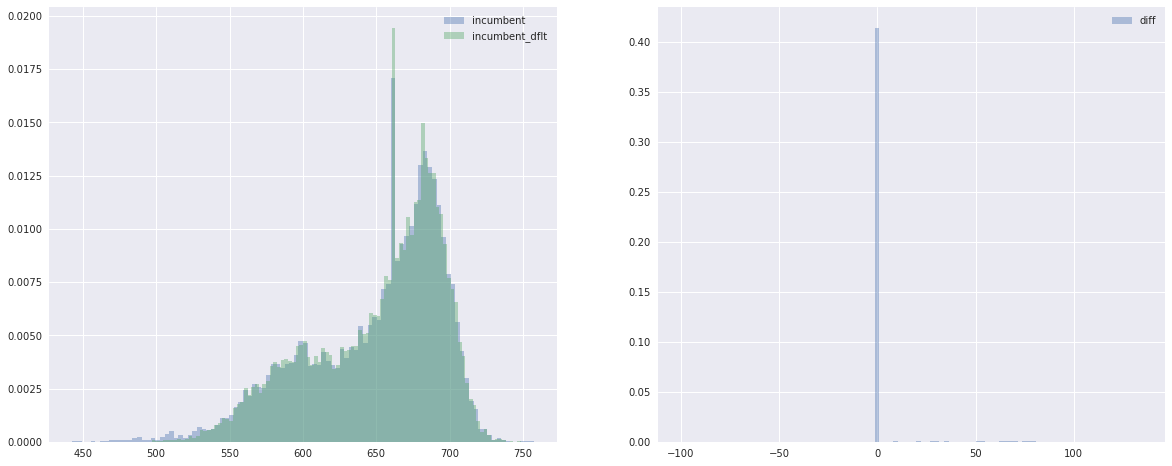

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt_params = {"alpha": 0.4,
              "bins": 100,
              "density": True}

ax = axs[0]
new_df_w_tgt["incumbent_model_score"].hist(**plt_params, label="incumbent", ax=ax)
new_df_w_tgt["incumbent_model_score_w_default"].hist(**plt_params, label="incumbent_dflt", ax=ax)
ax.legend()

ax = axs[1]
diff = new_df_w_tgt["incumbent_model_score_w_default"] - new_df_w_tgt["incumbent_model_score"]
diff.hist(**plt_params, label="diff", ax=ax)
ax.legend()

In [74]:
diff.value_counts(normalize=True)

 0.000000     0.971322
-17.189655    0.000110
 5.849190     0.000110
 9.770627     0.000055
 19.743135    0.000055
                ...   
 61.078699    0.000055
 76.928837    0.000055
 29.964754    0.000055
 29.126621    0.000055
-24.427079    0.000055
Length: 520, dtype: float64

In [78]:
(diff.abs() <= 1e-5).value_counts(normalize=True)

True     0.971322
False    0.028678
dtype: float64

In [ ]:
# only so many limited targets, needs to look deeper into it

No handles with labels found to put in legend.


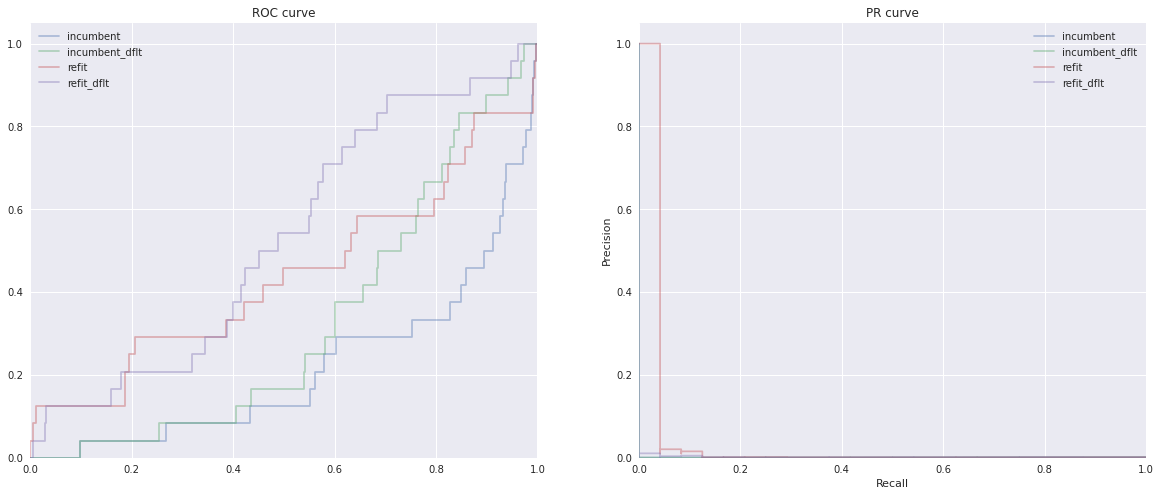

In [84]:
# performance
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult


fig, axs = plt.subplots(1, 2, figsize=(20,8))
df_ = new_df_w_tgt

preds = [
    (df_['incumbent_model_score'], 'incumbent'),
    (df_['incumbent_model_score_w_default'], 'incumbent_dflt'),
    (df_['refitted_model_score'], 'refit'),
    (df_['refitted_model_score_w_default'], 'refit_dflt'),
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(preds)]
title = 'ROC curve'
plot_auc_curve_mult(df_["target"], preds,
                    title=title, colors=colors,
                    fill_area=False,
                    ax=axs[0])
axs[0].legend()


title = 'PR curve'
plot_pr_curve_mult(df_["target"], preds,
                    title=title, colors=colors,
                    fill_area=False,
                    ax=axs[1])
axs[1].legend()



In [ ]:
# how about CM based on RGs?


##### find more data?

In [89]:
prod_df.head()

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,created_date
0,10835,2021-03-03 03:21:10.145,2021-10-27 02:27:10.380,2021-10-27,2021-10-27 02:27:10.379,"""RG1""","""scheduled""",427.113019,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,3,-1.0,-1.0,2021-03-03
1,13863,2021-10-27 03:58:06.808,None,2021-10-27,2021-10-27 03:58:06.803,"""RG2B""","""scheduled""",508.070244,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG2B""",...,10.0,87623.0,1.0,29248.0,1.0,3488.0,2,-1.0,-1.0,2021-10-27
2,14484,2020-08-05 07:02:57.426,2021-10-27 02:29:44.977,2021-10-27,2021-10-27 02:29:44.976,"""RG1""","""scheduled""",322.498492,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,14.0,60697.0,0.0,43506.0,0.0,17241.0,3,-1.0,-1.0,2020-08-05
3,21974,2020-08-05 06:17:29.450,2021-10-27 02:07:13.360,2021-10-27,2021-10-27 02:07:13.359,"""RG1""","""scheduled""",441.344522,"[{""ruleName"":""isMember"",""rulePassed"":true,""ris...","""RG1""",...,NaN,NaN,NaN,NaN,NaN,NaN,6,-1.0,-1.0,2020-08-05
4,26586,2020-09-30 02:15:15.361,2021-10-27 02:06:19.168,2021-10-27,2021-10-27 02:06:19.167,"""RG1""","""scheduled""",385.510656,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG1""",...,16.0,0.0,1.0,96000.0,0.0,2721.0,0,-1.0,-1.0,2020-09-30


In [90]:
prod_df.request_source.value_counts()

"scheduled"     1236857
"onboarding"     344210
"tenure"          11810
"return"           3269
"adhoc"               5
Name: request_source, dtype: int64

In [117]:
dt_cols = ["created_dt",
        "updated_dt",
        "last_checked_date",
        "last_checked_date_max"]
for d in dt_cols:
    prod_df[d] = pd.to_datetime(prod_df[d])

In [129]:
onboarding_df = prod_df[(prod_df.request_source=='"onboarding"')
                       & (prod_df.created_dt.dt.date==prod_df.last_checked_date.dt.date)]
onboarding_df.shape  

(330226, 57)

<AxesSubplot:>

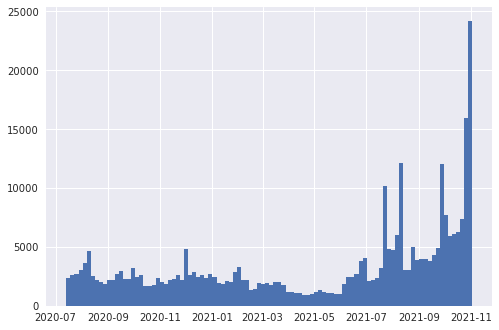

In [130]:
onboarding_df.created_dt.hist(bins=100)

In [135]:
new_df_w_tgt.target.value_counts()

False    18143
True        24
Name: target, dtype: int64

In [136]:
new_df_w_tgt.target.value_counts(normalize=True)

False    0.998679
True     0.001321
Name: target, dtype: float64

In [137]:
dev_df.target.value_counts()

False    1242610
True        3343
Name: target, dtype: int64

In [138]:
dev_df.target.value_counts(normalize=True)

False    0.997317
True     0.002683
Name: target, dtype: float64

In [ ]:
# 0.6% 